The purpose of this part is to analyse and explore the data to find features that are likely indicators of spam or ham.

Since, the body is the most significant field in an email and has the content that spammers use to exploit thier targets, we generate a word cloud from the body of all spam emails.

# Word Cloud

In [85]:
!pip install PyDrive

In [86]:
!pip install wordcloud

In [87]:
!pip install xlrd

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!rm -rf structured.xlsx

In [0]:
download = drive.CreateFile({'id': '1oh_fic0-1N1xh4OlTvGMQ5BTKjOmUYKi'})
download.GetContentFile('structured.xlsx')

In [92]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

There are certain words that spammers' use very commonly in their email's to catch the attention of their targets. We try to find such words from the email body by constructing a word cloud from our spam dataset. Bigger words in the word cloud are one's that occur more frequently in the dataset.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import re


Importing the excel file we created in part-1 into a pandas dataframe. We use a converter to convert all empty cell values to np.NaN and non-empty cell values to string type.

In [0]:
# converter
def conv(content):
    '''
    convert datatype to string or np.NaN
    '''
    # check for NaN 
    if(content != content):
        return np.NaN
    # else convert to string
    return str(content)
    

In [0]:
converters = {'Spam':conv, 'Body':conv, 'Subject':conv, 'From':conv, 'To':conv, 'X-UIDL':conv, 'Message-Id':conv, 'Sender':conv}

In [0]:
mails = pd.read_excel('structured.xlsx', index_col=None, converters=converters )

In [98]:
mails.head()

,Body,From,Message-Id,Spam,Subject,To,X-UIDL,Sender
0,increase your sales \n30% to 100% \nacce...,islander622@yahoo.com\n,<31867701_67397293>\n,Spam,Re: Your Merchant Account\n,usr999@aol.com\n,10293287_192832.222\n,NaN
1,"hi,\nwould you like to earn an extra $700 a we...",cm_offer@earthling.net\n,<36424144_99983662>\n,Spam,I thought you might be interested\n,you@yourdomain.net\n,20720340_201230.501\n,NaN
2,do you love cars?\n\nwant your own business?\n...,carlover@goplay.com\n,<>\n,Spam,AUTOMOBILE OPPORTUNITY\n,carlovers@america.com\n,NaN,NaN
3,"hi,\n\nwhat's in it for you? \n\n*************...",\t<info@clubcaddie.com>\n,<659888169528.7523837031@clubcaddie.com>\n,Spam,What's in it for me?\n,\tlinux-kernel@vger.rutgers.edu\n,NaN,owner-linux-kernel@vger.rutgers.edu\nPreceden...
4,NaN,list@ListMe.com\n,<199803270247.VAA16763@rover.listme.com>\n,Spam,Your Search Engine Listing\n\n,bguenter@gemprint.com \n\n Is your site l...,NaN,NaN


To filter out meaningless words and generate a cleaner word cloud, we use the nltk package to: 
1. remove all punctuation using regex & convert to lower case
2. Tokenize, stem (Porter stemmer) & remove stop words

In [0]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [0]:
def transformBody(body):
    '''
    data preprocessing steps
    '''
    # removing ' character (eg. dollar's -> dollars)
    # remove other puctuation
    body = str(body).replace("'", "")
    body = re.sub(r"[^\w\s]|_", "", body)
    #body = re.sub("[\s+]", " ", body)

    # to lower case
    bodylower = body.lower()
    
    # tokenize, stem and remove stop words
    bodylist = word_tokenize(bodylower)
    stemmer = PorterStemmer()
    stemmedlist = [stemmer.stem(word) for word in bodylist]
    sw = stopwords.words('english')
    finalist = [word for word in bodylist if(word not in sw)]
    return finalist

In [0]:
spamBodies = mails[mails['Spam'] == 'Spam']['Body']

In [0]:
spamBodies2 = spamBodies.map(transformBody)

In [0]:
spam_words = ' '.join(np.concatenate(spamBodies2.values.tolist()).tolist())

Using wordcloud package to generate the wordcloud.

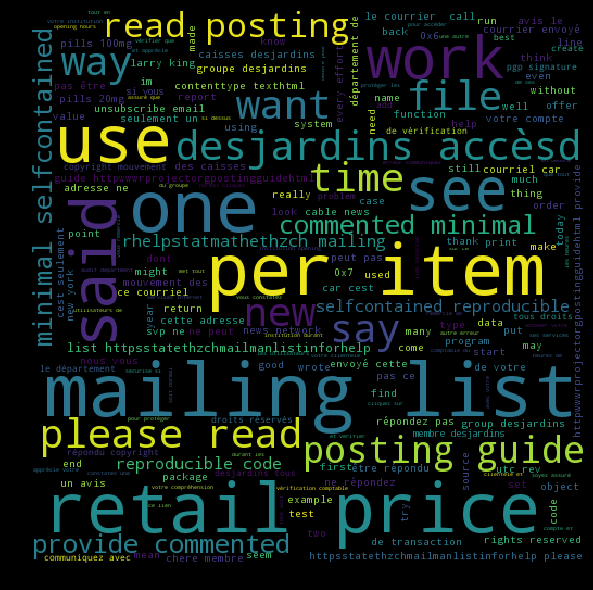

In [104]:
spam_wc = wordcloud.WordCloud(width=768, height=768).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [0]:
#spamBodies['whereHTML'] = spamBodies['Body'].apply(lambda x: x[x.find('tm3')-30:] if(str(x).find('tm3') != -1) else np.NaN)

In [0]:
#spamBodies[spamBodies['whereHTML'].notna()]['whereHTML']

In [0]:
#print(spamBodies.ix[41]['Body'])

## Engineering features from Email Headers

Email headers show the route an email has taken before arriving at its recipient. It contains important information like sender, recipient, message-id, date and time, subject etc. 

There are two reasons why spammers try to malform email headers.<br/>
    1.They try to conceil their identity and real source of the email.<br/>
    2.They try to conceil the fact that the email was part of a mass mailing effort.

FEATURE1: Spammers will sometimes enter all recipients in the Bcc field, and the address in the 'From' field is used in the 'To' field. Creating a new column 'Feature1' where 1 indicates 'From' field is the same as 'To' field, 0 indicates otherwise.

In [0]:
df_final = mails

In [110]:
# Feature1 -> From same as To. If yes -> 1, else 0
df_final['Feature1'] = 0
df_final.loc[df_final['From'] == df_final['To'], 'Feature1'] = 1
df_final['Feature1'].describe()

count    5039.000000
mean        0.002183
std         0.046676
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Feature1, dtype: float64

FEATURE2: Again, because spammers send out emails by filling the 'Bcc' field, they sometimes leave the 'To' field empty or with an invalid string. Creating a new column 'Feature2' where 1 indicates invalid or NaN 'To' field, 0 indicates otherwise.

The method defined below splits the passed string around the ',' character, to get individual email addresses, 
which are stripped off of the new line chars. Method can handle email address strings like 
`"Tomas Jacobs" <RickyAmes@aol.com>` also. Regex is then used to check format correctness

In [0]:
import re
def isValidEmailFormat(emails):
    '''
    regex to check valid email addresses where 0 is valid and 1 is invalid
    '''
    for email in str(emails).split(','):
        if(email.isspace() or len(email) == 0):
            continue
            
        email = re.sub(r'(\n+)', r' ', str(email)).strip()
        print(email)
        
        if(re.match(r"(.+)<(.+)>|<(.+)>", email)):
            email = email[email.find("<")+1:-1]
            print(0, email)
            
        if(len(email) > 7):
            if(re.match("^.+@([?)[a-zA-Z0-9-.]+.([a-zA-Z]{2,3}|[0-9]{1,3})(]?))$", email) != None):
                print('continue')
                continue
            else:
                print('1')
                return 1
        else:
            return 1
        
    return 0

In [112]:
# Feature2 -> is the To column na or invalid ? 1->invalid, 0->valid
df_final['Feature2'] = 0
df_final['Feature2'] = df_final['To'].map(isValidEmailFormat)
df_final.loc[df_final['To'].isna(),'Feature2'] = 1
df_final[df_final['Feature2'] == 1][['Feature2','To']]

usr999@aol.com
continue
you@yourdomain.net
continue
carlovers@america.com
continue
linux-kernel@vger.rutgers.edu
continue
bguenter@gemprint.com       Is your site listed with the top search engines?  ListMe will       list you with 50 search engines and indexes for $90.       Satisfaction guaranteed!  Search engines are the only way most people have to find internet sites. But if your site is not listed
1
bguenter@gemprint.com
continue
<bagpipes@acadia.net>
0 bagpipes@acadia.net
continue
user@aol.com
continue
bait@mikhail.qcc.sk.ca
continue
partner@mindlock.com
continue
bmail@bmail.com
continue
BeSeen@At.Our.Site.com
continue
easterbaskets@hotmail.com
continue
bmail@bmail.com
continue
healthNprosper@aol.com
continue
p40508@presence4u.com
continue
toto367.glossy.com@29086.com
continue
p40508@presence4u.com
continue
AmazingSecrets@WorldInner.Circle
continue
Shelley7247@juno.com
continue
CNC-L@UVVM.UVIC.CA
continue
wedeliver@hotmail.com
continue
tugei38@versant.de
continue
<badams@eastky.

,Feature2,To
4,1,bguenter@gemprint.com \n\n Is your site l...
28,1,NaN
30,1,bruce.guenter@gemprint.com \n\n Is your s...
38,1,bguenter@linus.vsource.com \n\n Is your s...
48,1,NaN
108,1,"""OtherRecipients of perl Ticket #43325"": ;\n"
139,1,"""Speakup is a screen review system for Linux...."
191,1,<producttestpanel@speedy.uwaterloo.ca>\nPrece...
197,1,ip-health@lists.essential.org\ncontent-transf...
201,1,avcooper@flax9.uwaterloo.ca\nPrecedence: list\n


FEATURE3: Since the 'Message-Id' contains information about where the email is coming from, in spam mails, it is typically missing or malformed. Message-Ids are of the form xxx@domain.com. The method below checks the correctness of the Message-Id format. Creating a new column 'Feature3' where 1 indicates Message-ID malformed or missing, 0 indicates otherwise. 

In [0]:
import re
def isValidMessageID(mid):
    '''
    checks for valid domain in message id where 0 is valid and 1 is invalid
    '''
    for email in str(mid).split('\n'):
        if(email.isspace() or len(email) == 0 or email.find('@') < 0):
            continue
            
        email = email.strip()
        print(email)
        
        if(re.match(r"(.+)?<<(.+)@(.+)>>(.+)?", email)):
            email = email[email.find("<<")+1:email.rfind(">>")]
            print(0, email)
        
        if(re.match(r"(.+)?<(.+)@(.+)>(.+)?", email)):
            email = email[email.find("<")+1:email.rfind(">")]
            print(0, email)
            
        if(len(email) > 7):
            if(re.match("^.+@([?)[a-zA-Z0-9-.]+.([a-zA-Z]{2,3}|[0-9]{1,3})(]?))$", email) != None):
                return 0
            else:
                continue
        else:
            continue
        
    return 1

Displaying Message-Id values that are malformed.

In [114]:
# Feature3 -> is the Message-Id column na or invalid ? 1->invalid, 0->valid
df_final['Feature3'] = 0
df_final['Feature3'] = df_final['Message-Id'].map(isValidMessageID)
df_final.loc[df_final['Message-Id'].isna(),'Feature3'] = 1
df_final.loc[df_final['Feature3'] == 1][['Feature3','Message-Id']]

<659888169528.7523837031@clubcaddie.com>
0 659888169528.7523837031@clubcaddie.com
<199803270247.VAA16763@rover.listme.com>
0 199803270247.VAA16763@rover.listme.com
<19943672.886214@relay.comanche.denmark.eu> Monday, February 2nd, 1998
0 19943672.886214@relay.comanche.denmark.eu
<<34B589AA.83376E4D@hotmail.com>>
0 <34B589AA.83376E4D@hotmail.com
<199803310903.CAA23676@infonews.co.th>
0 199803310903.CAA23676@infonews.co.th
<199702170025.GAA08056@bmail.com>
0 199702170025.GAA08056@bmail.com
<199803270121.TAA11252@linus.vsource.com>
0 199803270121.TAA11252@linus.vsource.com
<199803280745.CAA20386@director.monti.net>
0 199803280745.CAA20386@director.monti.net
<199702170025.GAA08056@bmail.com>
0 199702170025.GAA08056@bmail.com
<199803235011.qaa77856@aol.com>
0 199803235011.qaa77856@aol.com
<1321056421-24728912@cupertino.metrowerks.com>
0 1321056421-24728912@cupertino.metrowerks.com
<<188803273392RAA25542@mailhost.prodigy.net>>
0 <188803273392RAA25542@mailhost.prodigy.net
<0EQG00DSE4M7MP@PM04S

,Feature3,Message-Id
0,1,<31867701_67397293>\n
1,1,<36424144_99983662>\n
2,1,<>\n
5,1,<199803250408.UAA03361>\n
8,1,Mach10 1.1 fxpromo.com\n
21,1,<tryitbeforeyoubuyit>\n
31,1,199803272113.OOB5051@\n
32,1,NaN
34,1,NaN
35,1,<>\n


FEATURE4: The 'X-UIDL' header is intended to stop the recepient's mail server from downloading multiple copies of the mail once the mail is received. Normally, X-UIDL is stripped once the mail is received. Spammers' intentionally add the X-UIDL, so that mail servers download multiple copies of the mail, increasing chances of it being read. Creating a new column 'Feature4', where 1 indicates X-UIDL not empty, 0 indicates otherwise.

Displaying rows where X-UIDL is not empty.

In [115]:
# Feature4, is the X-UIDL header not empty or na ? 1->not empty, 0->empty 
df_final['Feature4'] = 0
df_final.loc[df_final['X-UIDL'].notna(), 'Feature4'] = 1
df_final.loc[df_final['X-UIDL'].isna(), 'Feature4'] = 0
df_final.loc[df_final['Feature4']==1]['X-UIDL']

0                   10293287_192832.222\n
1                   20720340_201230.501\n
7      c89dd4e061ba173523703cf25c3133a2\n
10     2610431056a78aeb1b128fda426c9a5e\n
12     33587715159195856343749765328732\n
13     2610431056a78aeb1b128fda426c9a5e\n
14                      123456789012376\n
18     f2c3e4bf7654f32bfd17a6c54dc32f1d\n
21     11111111111111111111111111111111\n
25     763cf6e5123c1287a83f12d7e99c60c9\n
31                        870483442.265\n
Name: X-UIDL, dtype: object

In [116]:
s = df_final[df_final['Spam'] == 'Ham']['Feature2']
s0 = s[s == 0]
s1 = s[s == 1]
print('Ham', 'Valid To field', s0.count())
ham_feature2 = s1.count()
print('Ham', 'InValid To field', ham_feature2)

s = df_final[df_final['Spam'] == 'Spam']['Feature2']
s0 = s[s == 0]
s1 = s[s == 1]
print('Spam', 'Valid To field', s0.count())
spam_feature2 = s1.count()
print('Spam', 'InValid To field', spam_feature2)

Ham Valid To field 1350
Ham InValid To field 46
Spam Valid To field 3497
Spam InValid To field 146


In [117]:
s = df_final[df_final['Spam'] == 'Ham']['Feature3']
s0 = s[s == 0]
s1 = s[s == 1]
print('Ham', 'Valid Message-Id field', s0.count())
ham_feature3 = s1.count()
print('Ham', 'InValid Message-Id field', ham_feature3)

s = df_final[df_final['Spam'] == 'Spam']['Feature3']
s0 = s[s == 0]
s1 = s[s == 1]
print('Spam', 'Valid Message-Id field', s0.count())
spam_feature3 = s1.count()
print('Spam', 'InValid Message-Id field', spam_feature3)

Ham Valid Message-Id field 1349
Ham InValid Message-Id field 47
Spam Valid Message-Id field 3487
Spam InValid Message-Id field 156


In [118]:
s = df_final[df_final['Spam'] == 'Ham']['Feature4']
s0 = s[s == 0]
s1 = s[s == 1]
print('Ham', 'empty X-UIDL field', s0.count())
ham_feature4 = s1.count()
print('Ham', 'Not empty X-UIDL field', ham_feature4)

s = df_final[df_final['Spam'] == 'Spam']['Feature4']
s0 = s[s == 0]
s1 = s[s == 1]
print('Spam', 'Empty X-UIDL field', s0.count())
spam_feature4 = s1.count()
print('Spam', 'Not empty X-UIDL field', spam_feature4)

Ham empty X-UIDL field 1396
Ham Not empty X-UIDL field 0
Spam Empty X-UIDL field 3632
Spam Not empty X-UIDL field 11


In [119]:
s = df_final[df_final['Spam'] == 'Ham']['Feature1']
s0 = s[s == 0]
s1 = s[s == 1]
print('Ham', 'Different From and To', s0.count())
ham_feature1 = s1.count()
print('Ham', 'Same From and To', ham_feature1)

s = df_final[df_final['Spam'] == 'Spam']['Feature1']
s0 = s[s == 0]
s1 = s[s == 1]
print('Spam', 'Different From and To', s0.count())
spam_feature1 = s1.count()
print('Spam', 'Same From and To', spam_feature1)

Ham Different From and To 1396
Ham Same From and To 0
Spam Different From and To 3632
Spam Same From and To 11


In [127]:
x_data = (1,2,3,4)
y_data = np.array([[spam_feature1,spam_feature2,spam_feature3,spam_feature4],[ham_feature1,ham_feature2,ham_feature3,ham_feature4]])
y_sum = y_data[0]+y_data[1]


203

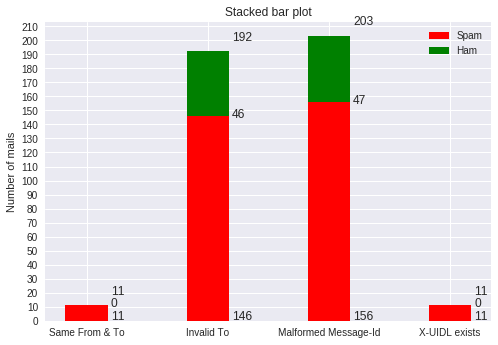

In [136]:
p1 = plt.bar(x_data,y_data[0],color='r',align='center',label=['f1','f2','f3','f4'], width=0.35)
p2 = plt.bar(x_data,y_data[1],color='g',bottom=y_data[0],align='center',label=['f1','f2','f3','f4'], width=0.35)
plt.ylabel('Number of mails')
plt.title('Stacked bar plot')
plt.xticks(x_data, ('Same From & To','Invalid To','Malformed Message-Id','X-UIDL exists'))
plt.yticks(np.arange(0,np.max(y_sum)+10,10))
plt.legend((p1[0],p2[0]),('Spam','Ham'),loc = 'upper right')

plt.text(1.20,1,spam_feature1)
plt.text(1.20,spam_feature1-1,ham_feature1)
plt.text(1.20,spam_feature1+ham_feature1+8,y_sum[0])

plt.text(2.20,1,spam_feature2)
plt.text(2.20,spam_feature2-1,ham_feature2)
plt.text(2.20,spam_feature2+ham_feature2+8,y_sum[1])

plt.text(3.20,1,spam_feature3)
plt.text(3.20,spam_feature3-1,ham_feature3)
plt.text(3.20,spam_feature3+ham_feature3+8,y_sum[2])

plt.text(4.20,1,spam_feature4)
plt.text(4.20,spam_feature4-1,ham_feature4)
plt.text(4.20,spam_feature4+ham_feature4+8,y_sum[3])

plt.show()